https://github.com/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/cohorts/2025/homework%203.md

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score

# Question 1: Dummies for Month and Week-of-Month

### 1.1 Read the data

In [4]:
# download data 
# import gdown
#URL = 'https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing'
#!gdown $URL --fuzzy -O ../data

In [5]:
df_full = pd.read_parquet('../data/stocks_df_combined.parquet')
print(df_full.shape)
df_full.head()

(230262, 203)


,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
0,0.054277,0.062259,0.054277,0.059598,1.031789e+09,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.059598,0.062791,0.059598,0.061726,3.081600e+08,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.061726,0.063323,0.061726,0.062791,1.331712e+08,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.062791,0.063323,0.060662,0.061194,6.776640e+07,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.061194,0.061726,0.059598,0.060130,4.789440e+07,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_full.columns[:15]

Index(['Open', 'High', 'Low', 'Close_x', 'Volume', 'Dividends', 'Stock Splits',
       'Ticker', 'Year', 'Month', 'Weekday', 'Date', 'growth_1d', 'growth_3d',
       'growth_7d'],
      dtype='object')

In [7]:
# compute the week of the month:
df_full['week_of_month'] = df_full['Date'].apply(lambda d: (d.day-1) // 7 + 1).astype(str)
df_full['Month'] = df_full['Month'].dt.strftime('%B').str.lower()
df_full['Weekday'] = df_full['Weekday'].astype(str)

In [8]:
# Create a new string variable that combines the month name and week of the month. 
# Example: 'October_w1', 'November_w2', etc.
df_full['month_wom'] = df_full['Month']+'_'+df_full['week_of_month']
df_full['month_wom'].head()

0    march_2
1    march_2
2    march_3
3    march_3
4    march_3
Name: month_wom, dtype: object

### 1.2 Define columns

In [9]:
# let's define on more custom numerical features
df_full['ln_volume'] = df_full['Volume'].apply(lambda x: np.log(x))

/tmp/ipykernel_4392/4076114231.py:2: RuntimeWarning: divide by zero encountered in log
  df_full['ln_volume'] = df_full['Volume'].apply(lambda x: np.log(x))


In [10]:
TARGET = 'is_positive_growth_30d_future'
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']
MONTH_VOM = df_full['month_wom'].unique().tolist()

In [11]:
TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [12]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [13]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [14]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [15]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]
OTHER

['Close_x',
 'Dividends',
 'Stock Splits',
 'growth_future_30d',
 'is_positive_growth_30d_future',
 'Close_y',
 'week_of_month']

In [16]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01'].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 206 entries, Open to ln_volume
dtypes: datetime64[ns](2), float64(130), int32(63), int64(5), object(6)
memory usage: 256.8+ MB


### 1.3 Define dummies

In [17]:
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')
print(dummy_variables.shape)
dummy_variables.head()

(191795, 115)


,Month_april,Month_august,Month_december,Month_february,Month_january,Month_july,Month_june,Month_march,Month_may,Month_november,...,month_wom_october_1,month_wom_october_2,month_wom_october_3,month_wom_october_4,month_wom_october_5,month_wom_september_1,month_wom_september_2,month_wom_september_3,month_wom_september_4,month_wom_september_5
3490,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3491,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3492,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3493,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3494,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)
print(df_with_dummies.shape)
df_with_dummies.info()

(191795, 321)
<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 321 entries, Open to month_wom_september_5
dtypes: datetime64[ns](2), float64(130), int32(178), int64(5), object(6)
memory usage: 340.9+ MB


In [19]:
DUMMIES = dummy_variables.columns.to_list()

### 1.4 Correlation analysis

In [20]:
# compute the correlation between each feature and the target variable is_positive_growth_30d_future.
corr_is_positive_growth_30d_future = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()[TARGET]

In [21]:
# Filter the correlation results to include only the dummy variables generated from month_wom
df_corr_filtered = pd.DataFrame(corr_is_positive_growth_30d_future[corr_is_positive_growth_30d_future.index.str.startswith('month_wom')])
df_corr_filtered.head()

,is_positive_growth_30d_future
month_wom_april_1,-0.001600
month_wom_april_2,-0.002640
month_wom_april_3,0.006208
month_wom_april_4,0.004110
month_wom_april_5,0.001731


In [22]:
# Create a new column named `abs_corr` in the correlation results that stores the absolute value of the correlations.
df_corr_filtered['abs_corr'] = abs(df_corr_filtered[TARGET])
df_corr_filtered.head()

,is_positive_growth_30d_future,abs_corr
month_wom_april_1,-0.001600,0.001600
month_wom_april_2,-0.002640,0.002640
month_wom_april_3,0.006208,0.006208
month_wom_april_4,0.004110,0.004110
month_wom_april_5,0.001731,0.001731


In [23]:
# Sort the correlation results by abs_corr in descending order.
df_corr_filtered.sort_values('abs_corr', ascending=False, inplace=True)
df_corr_filtered.head()

,is_positive_growth_30d_future,abs_corr
month_wom_october_4,0.024968,0.024968
month_wom_november_3,0.022097,0.022097
month_wom_november_2,0.018822,0.018822
month_wom_january_2,-0.018327,0.018327
month_wom_october_3,0.017734,0.017734


In [24]:
# Identify and report the highest absolute correlation value among the month_wom dummy variables, rounded to three decimal places.
df_corr_filtered.iloc[0]['abs_corr'].round(3)

np.float64(0.025)

# Question 2: Define New "Hand" Rules on Macro and Technical Indicator Variables

### 2.1 Split the data

In [25]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [26]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()
min_date_df, max_date_df

(Timestamp('2000-01-03 00:00:00'), Timestamp('2025-06-13 00:00:00'))

In [27]:
df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [28]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.676399
test          0.163758
validation    0.159843
Name: count, dtype: float64

In [29]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

### 2.2 Manual "hand rule" predictions

In [30]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df['cci']>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df['growth_30d']>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_30d'] > 1) & (new_df['growth_snp500_30d'] > 1)).astype(int)

In [31]:
# Define two new 'hand' rules based on branches that lead to 'positive' predictions in the tree:
# pred3_manual_dgs10_5 (DGS10 <= 4) & (DGS5 <= 1)
# pred4_manual_dgs10_fedfunds (DGS10 > 4) & (FEDFUNDS <= 4.795)
new_df['pred3_manual_dgs10_5'] = ((new_df['DGS10'] <= 4) & (new_df['DGS5'] <= 1)).astype(int)
new_df['pred4_manual_dgs10_fedfunds'] = ((new_df['DGS10'] > 4) & (new_df['FEDFUNDS'] <= 4.795)).astype(int)
new_df[['pred3_manual_dgs10_5','pred4_manual_dgs10_fedfunds']].head()

,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds
3490,0,0
3491,0,0
3492,0,0
3493,0,0
3494,0,0


In [32]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds']

In [33]:
# generate columns is_correct_
for pred in PREDICTIONS:
  part1 = pred.split('_')[0] # first prefix before '_'
  new_df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[TARGET]).astype(int)

In [34]:
# IS_CORRECT dataset
IS_CORRECT =  [k for k in new_df.keys() if k.startswith('is_correct_')]
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4']

In [35]:
# sample of a dataframe
new_df[PREDICTIONS+IS_CORRECT+[TARGET]].sample(5)

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_30d_future
2219,0,1,0,0,0,1,0,1,1,1,0
4270,0,1,1,1,0,1,0,0,0,1,0
2612,0,1,1,1,0,1,0,0,0,1,0
3969,0,1,1,0,0,1,0,0,1,1,0
2022,0,0,0,0,0,0,0,0,0,0,1


In [36]:
# define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    p_score = precision_score(new_df[filter][TARGET], new_df[filter][prediction_column])
    print(f'precission score {p_score:.3f} for prediction column: {prediction_column}, is_correct_column: {is_correct_column}')
    #print(new_df[filter][is_correct_column].value_counts())
    #print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    #print('---------')
    #print()

precission score 0.558 for prediction column: pred0_manual_cci, is_correct_column: is_correct_pred0
precission score 0.542 for prediction column: pred1_manual_prev_g1, is_correct_column: is_correct_pred1
precission score 0.522 for prediction column: pred2_manual_prev_g1_and_snp, is_correct_column: is_correct_pred2
precission score 0.580 for prediction column: pred3_manual_dgs10_5, is_correct_column: is_correct_pred3
precission score 0.466 for prediction column: pred4_manual_dgs10_fedfunds, is_correct_column: is_correct_pred4


####  What's the precision score for the best new rule? 
Ans: 0.580 for pred3_manual_dgs10_5

# Question 3: Unique Correct Predictions from a 10-Level Decision Tree Classifier (pred5_clf_10)

### 3.1 Split the data

In [37]:
# Split the data into training and testing sets based on the split date
features_list = NUMERICAL+DUMMIES

In [38]:
train_df = new_df[new_df['split'].isin(['train','validation'])]
test_df = new_df[new_df['split'].isin(['test'])]
val_df = new_df[new_df['split'].isin(['validation'])]
train_df.shape, test_df.shape, val_df.shape

((160387, 332), (31408, 332), (30657, 332))

In [39]:
# ONLY numerical Separate features and target variable for training and testing sets
# need Date and Ticker later when merging predictions to the dataset
def get_X_y(df, suffix=''):
    X = df[features_list+[TARGET,'Date','Ticker']].copy()
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Need to fill NaNs somehow
    X.fillna(0, inplace=True)
    y = X.pop(TARGET).values
    print(f'length: X_{suffix} {X.shape}, y_{suffix} {len(y)}')
    return X, y

X_train, y_train = get_X_y(train_df, 'train')
X_test, y_test = get_X_y(test_df, 'test')
X_val, y_val = get_X_y(val_df, 'val')
X_full, y_full = get_X_y(new_df, 'full')

length: X_train (160387, 301), y_train 160387
length: X_test (31408, 301), y_test 31408
length: X_val (30657, 301), y_val 30657
length: X_full (191795, 301), y_full 191795


### 3.2 Fit the DecisionTreeClassifier

In [42]:
# Initialize a Decision Tree Classifier with a maximum depth of 10 and set random_state=42 for reproducibility.
model = DecisionTreeClassifier(max_depth=10, random_state=42) 

In [43]:
# Fit the classifier on the combined TRAIN and VALIDATION datasets
model.fit(X_train.drop(['Date','Ticker'],axis=1), y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

### 3.3 Make predicts

In [44]:
# Use the trained model to predict on the entire dataset (TRAIN + VALIDATION + TEST)
y_pred = model.predict(X_full.drop(['Date','Ticker'],axis=1))

In [45]:
# Store these predictions in a new column named pred5_clf_10 within your main dataframe.
new_df['pred5_clf_10'] = y_pred

### 3.4 Evaluate the model

In [46]:
# Create a new boolean column, only_pred5_is_correct, that is True only when:
#  The prediction from pred5_clf_10 is correct (i.e., matches the true label).
#  All other hand rule predictions (pred0 through pred4) are incorrect.
new_df['only_pred5_is_correct'] = (new_df['pred5_clf_10'] == new_df[TARGET]) & (new_df[IS_CORRECT].sum(axis=1) == 0)

In [47]:
# Filter the dataframe for records belonging to the TEST dataset.
# Count how many records in the TEST set have only_pred5_is_correct equal to 1.
new_df.query("split == 'test'")['only_pred5_is_correct'].sum()

np.int64(3770)

In [68]:
# Ans: 3770

# Question 4: Hyperparameter tuning for a Decision Tree

In [48]:
# What is the optimal tree depth (from 1 to 20) for a DecisionTreeClassifier?
results = []
for max_depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)  

    # Train a Decision Tree Classifier with the current max_depth on the combined TRAIN+VALIDATION dataset.
    model.fit(X_train.drop(['Date','Ticker'],axis=1), y_train)

    # Calculate the precision score on the TEST dataset for each fitted tree. 
    precission_test = precision_score(y_test,  model.predict(X_test.drop(['Date','Ticker'],axis=1)))
    precission_val = precision_score(y_val, model.predict(X_val.drop(['Date','Ticker'],axis=1)))

    results.append([max_depth, precission_test, precission_val])

[1, 0.5465816507261778, 0.6400495808461363]
[2, 0.5510697911360163, 0.6400495808461363]
[3, 0.5510697911360163, 0.6400495808461363]
[4, 0.5510697911360163, 0.644022196065243]
[5, 0.627845220030349, 0.717542250753308]
[6, 0.5691415110800907, 0.7121739130434782]
[7, 0.5938485804416404, 0.7172139383465295]
[8, 0.5897136702270891, 0.7414014373716632]
[9, 0.5915457349446327, 0.7604434589800444]
[10, 0.5889278426037361, 0.7585901224145208]
[11, 0.5947726306842329, 0.7876538820496867]
[12, 0.5788757932910245, 0.7947124223058741]
[13, 0.5828431861230187, 0.8095887998591177]
[14, 0.57773410527434, 0.8248644837160107]
[15, 0.5854521696520935, 0.8570831203828463]
[16, 0.5904395868364161, 0.8768780119058868]
[17, 0.5885812962063569, 0.8868740016912524]
[18, 0.585290999386195, 0.9058469475494411]
[19, 0.5856247284464031, 0.9319513516175095]
[20, 0.5811975315505643, 0.9386063295460086]


In [49]:
df_results = pd.DataFrame(results, columns=['max_depth','precission_test','precission_val'])
df_results.head()

,max_depth,precission_test,precission_val
0,1,0.546582,0.640050
1,2,0.551070,0.640050
2,3,0.551070,0.640050
3,4,0.551070,0.644022
4,5,0.627845,0.717542


In [61]:
# Identify the optimal max_depth where the precision score on the TEST dataset is highest. 
# This value is your best_max_depth.
df_results.sort_values(by='precission_test', ascending=False).head(1)

,max_depth,precission_test,precission_val
4,5,0.627845,0.717542


In [69]:
# Ans: 5 is the best max_depth for a Decision Tree Classifier

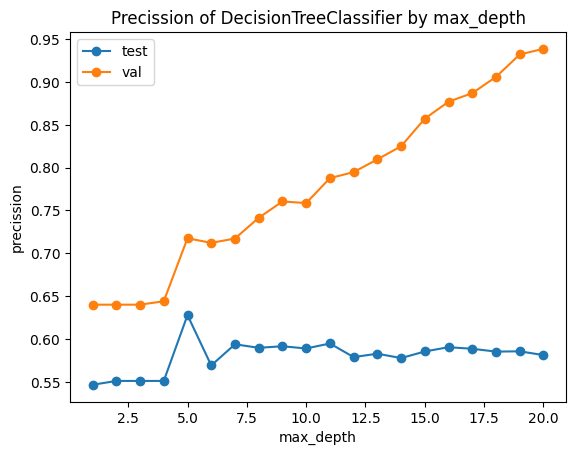

In [60]:
# Plot the precision (or accuracy) scores against the max_depth values to detect saturation or overfitting trends.
plt.plot(df_results['max_depth'], df_results['precission_test'], label='test', marker='o')
plt.plot(df_results['max_depth'], df_results['precission_val'], label='val', marker='o')
plt.title('Precission of DecisionTreeClassifier by max_depth')
plt.xlabel('max_depth')
plt.ylabel('precission')
plt.legend();

In [62]:
model = DecisionTreeClassifier(max_depth=5, random_state=42)  
model.fit(X_train.drop(['Date','Ticker'],axis=1), y_train)
y_pred = model.predict(X_full.drop(['Date','Ticker'],axis=1))
new_df['pred6_clf_best'] = y_pred

In [63]:
# Compare the precision score of the tuned tree with previous predictions (pred0 to pred5). 
# You should observe an improvement, ideally achieving precision > 0.58, indicating the tuned tree outperforms earlier models.
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_best']

In [64]:
# generate columns is_correct_
for pred in PREDICTIONS:
  part1 = pred.split('_')[0] # first prefix before '_'
  new_df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[TARGET]).astype(int)

In [65]:
# IS_CORRECT dataset
IS_CORRECT =  [k for k in new_df.keys() if k.startswith('is_correct_')]
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4',
 'is_correct_pred5',
 'is_correct_pred6']

In [67]:
# define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    p_score = precision_score(new_df[filter][TARGET], new_df[filter][prediction_column])
    print(f'precission score {p_score:.3f} for prediction column {prediction_column}')

precission score 0.558 for prediction column pred0_manual_cci
precission score 0.542 for prediction column pred1_manual_prev_g1
precission score 0.522 for prediction column pred2_manual_prev_g1_and_snp
precission score 0.580 for prediction column pred3_manual_dgs10_5
precission score 0.466 for prediction column pred4_manual_dgs10_fedfunds
precission score 0.589 for prediction column pred5_clf_10
precission score 0.628 for prediction column pred6_clf_best


#### The model with the tuned DT hyperparameters showed the best precission score (0.628)